In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import contextlib
import einops
import pandas as pd
import dotenv
dotenv.load_dotenv()

from huggingface_hub import login

HF_ACCESS_TOKEN = os.getenv("HF_ACCESS_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
if HF_ACCESS_TOKEN:
    login(token=HF_ACCESS_TOKEN)
    print("Successfully authenticated with Hugging Face.")
else:
    print("Hugging Face access token not found in environment variables.")

if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    print("Successfully authenticated with Weights & Biases.")
else:
    print("Weights & Biases API key not found in environment variables.")


/root/sae-editing
Successfully authenticated with Hugging Face.
Successfully authenticated with Weights & Biases.


In [2]:
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"
pretrained_path = None

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

dtype = torch.bfloat16
if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from tasks.wmdp.WMDP_MCTask import WMDP_MCTask
from tasks.wmdp.WMDP_RelearnTask import WMDP_RelearnTask
from tasks.general_capabilities.MCTask_redo import run_general_evals
batch_size = 16
bio_mc_task = WMDP_MCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True)
print(bio_mc_task.dataset)

Dataset({
    features: ['answer', 'question', 'choices', 'prompt'],
    num_rows: 1273
})


In [4]:
# acc = 0
num_iters = len(bio_mc_task.dataset) // batch_size
# for i in tqdm(range(n_iters)):
#     acc += bio_mc_task.get_test_accuracy(model)
# acc /= n_iters
# acc

acc = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
print(f"Biology accuracy: {acc}")

mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
print(f"MMLU accuracy: {mmlu['MMLU']}")


# print("Accuracy for Gemma 2 9B: 72%")


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Biology accuracy: 0.7183544303797469


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU accuracy is 0.73
MMLU accuracy: 0.73


## Find Relevant SAE Features

In [5]:
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=500)
print(pile_task.get_batch())

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [6]:
bio_ce_task.dataset.push_to_hub("PhillipGuo/cais-wmdp-bio-forget", private=True)

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/PhillipGuo/cais-wmdp-bio-forget/commit/8e83e52f3eec1575d43cf8cbc7548c8d78521f6e', commit_message='Upload dataset', commit_description='', oid='8e83e52f3eec1575d43cf8cbc7548c8d78521f6e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/PhillipGuo/cais-wmdp-bio-forget', endpoint='https://huggingface.co', repo_type='dataset', repo_id='PhillipGuo/cais-wmdp-bio-forget'), pr_revision=None, pr_num=None)

In [7]:
from sae_lens import SAE

sae_type = "16k"
# sae_layer = 21

sae_dict = {}

sae_layers = [7, 14, 21, 28, 35]
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    if sae_type == "131k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    elif sae_type == "16k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    
    # for param in sae.parameters():
    #     param.data = param.data.to(torch.bfloat16)

    sae_dict[layer] = sae


  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states

  # target_act = None
  # def gather_target_act_hook(mod, inputs, outputs):
  #   nonlocal target_act # make sure we can modify the target_act from the outer scope
  #   target_act = outputs[0]
  #   return outputs
  # handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  # _ = model.forward(**inputs)
  # handle.remove()
  # return target_act

In [9]:
def get_sae_acts(model, sae, task, n_batches=10, ctx_len=500, text_key="text", return_tokens=True):
    all_sae_acts = []
    for batch_idx in tqdm(range(n_batches)):
        batch = task.get_batch()[text_key]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=ctx_len)
        inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
            with torch.amp.autocast(device_type="cuda"):
                sae_acts = sae.encode(target_act)
        all_sae_acts.append(sae_acts.cpu())
    return torch.cat(all_sae_acts, dim=0)

load_sparsity_dfs = True

if load_sparsity_dfs:
    sparsity_dfs = {}
    for sae_layer in sae_layers:
        sparsity_dfs[sae_layer] = pd.read_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
else:
    sparsity_dfs = {}
    for sae_layer in sae_layers:

        sae = sae_dict[sae_layer]
        if next(sae.parameters()).device.type != "cuda":
            sae = sae.cuda()


        pile_sae_acts = get_sae_acts(model, sae, pile_task, n_batches=50, ctx_len=500, text_key="text")
        print(pile_sae_acts.shape)
        pile_sparsities = (pile_sae_acts > 0).float().mean(dim=0)

        bio_sae_acts = get_sae_acts(model, sae, bio_ce_task, n_batches=50, ctx_len=500, text_key="abstract")
        print(bio_sae_acts.shape)
        bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0)

        sae = sae.cpu()
        sparsity_df = pd.DataFrame({"pile_sparsity": pile_sparsities, "bio_sparsity": bio_sparsities})
        sparsity_df.to_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
        sparsity_dfs[sae_layer] = sparsity_df

### SAE Stats

In [20]:
sparsity_df = sparsity_dfs[7]
filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
filtered_bio_sparsity.sort_values(ascending=False).head(200).index.tolist()


[11888,
 7857,
 9206,
 7154,
 16029,
 9272,
 14335,
 14816,
 3720,
 154,
 13445,
 6888,
 6321,
 5985,
 10520,
 13727,
 1963,
 10231,
 906,
 6223,
 15753,
 9194,
 1126,
 9545,
 15041,
 1414,
 16121,
 13945,
 4506,
 13587,
 9002,
 8953,
 836,
 15958,
 15844,
 3948,
 15627,
 4561,
 15199,
 11809,
 10063,
 2918,
 9347,
 7170,
 13511,
 11877,
 3645,
 4518,
 15813,
 14434,
 9422,
 9476,
 6017,
 7111,
 7894,
 12643,
 4318,
 2989,
 13165,
 12858,
 4097,
 15111,
 10873,
 2012,
 10402,
 6778,
 15170,
 11875,
 13166,
 11262,
 4481,
 7231,
 14980,
 1827,
 5382,
 8467,
 8497,
 15186,
 9085,
 5459,
 1841,
 6980,
 8323,
 5622,
 13228,
 5151,
 239,
 8057,
 2128,
 7670,
 7350,
 13703,
 4775,
 11159,
 13200,
 2516,
 6148,
 7987,
 10437,
 14606,
 15344,
 3862,
 14409,
 5813,
 6435,
 566,
 13723,
 3377,
 2798,
 8803,
 2869,
 13916,
 2163,
 12275,
 4737,
 15878,
 1390,
 13671,
 15118,
 13383,
 8082,
 5300,
 15216,
 12644,
 3370,
 8753,
 13497,
 5318,
 10962,
 14289,
 9505,
 4324,
 10958,
 10959,
 10310,
 1

In [11]:
# which features have sparsity > 0.01 on pile?
pile_mask = (pile_sae_acts > 0).float().mean(dim=0) <= 0.01

# multiply by mask so that we filter out all features that are also common on pile
bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0) * pile_mask

# rank indices by sparsity
bio_sparsities_sorted = bio_sparsities.sort(descending=True)
bio_sparsities_sorted

NameError: name 'pile_sae_acts' is not defined

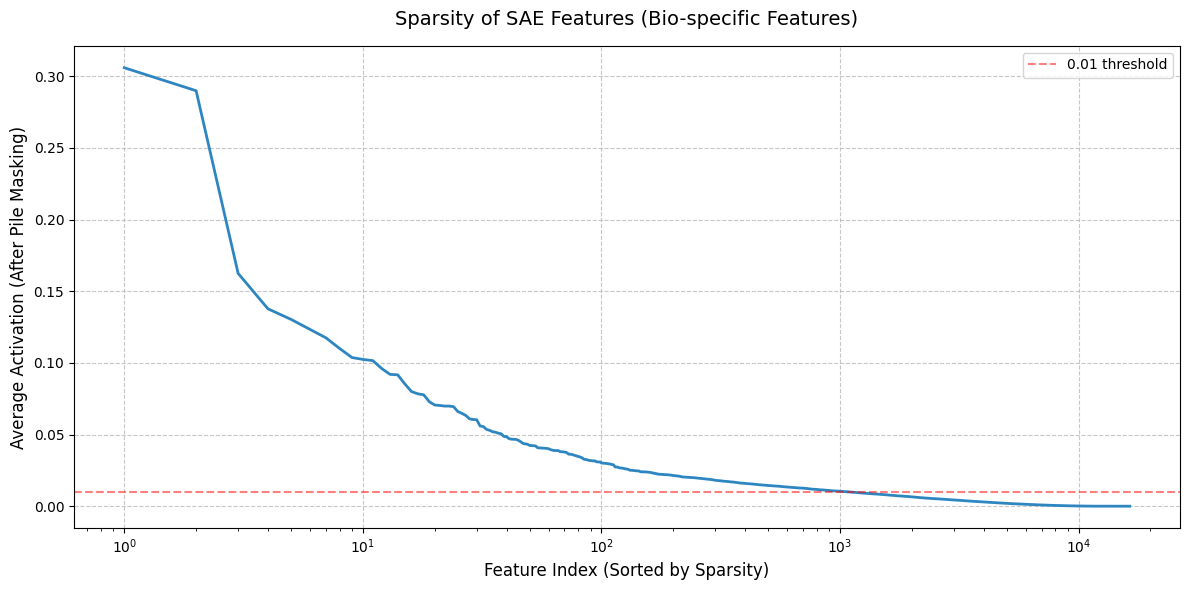

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bio_sparsities_sorted.values) + 1), bio_sparsities_sorted.values, linewidth=2, color='#2E86C1')

plt.title('Sparsity of SAE Features (Bio-specific Features)', fontsize=14, pad=15)
plt.xlabel('Feature Index (Sorted by Sparsity)', fontsize=12)
plt.ylabel('Average Activation (After Pile Masking)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
# plt.yscale('log')  # Log scale often helps visualize sparsity patterns better
plt.xscale('log')

# Add a horizontal line at 0.01 for reference
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='0.01 threshold')

plt.legend()
plt.tight_layout()

In [12]:
print(f"Layer {sae_layer}, {sae_type} SAE top features")
print(bio_sparsities_sorted.indices[:200])

Layer 21, 16k SAE top features
tensor([ 4946,  1013,  9879,  9715, 11463,  2006, 10496,  6620,  3300,  3179,
        10422, 14570,  1459,  7340, 12231,  3706,  6170,  7078, 11002, 11136,
        10307, 12443,  3823,  8465,  2811,  5079,  8824,  8627,  8834,    17,
         5202, 10639,  2708,  5193,  7194, 14384,   180,  3337,  7144,  7593,
        13671, 11279,  2632, 12450, 13344,  8455, 11588,  1074,  9437,  2275,
        10061,  9920,  4735, 14427,  9598,  9333,    18, 14221,  7290,  1274,
         9469,  6551,  4373,  7779, 10066,  7715,  4574,  6085,  3144, 13094,
         4887, 16215, 15849,  3275, 13529,  5062,   826,  7999,  6466, 13517,
         8387,  7879,  2222,  5702,  7151,  8647,  4640, 11196,  6356,  3313,
         5991,  9115,  1061,   929, 14946, 15078, 11452, 14235,  4817,  9467,
         9708,  4116, 14100, 13096, 13132, 16122,  4455,  9902, 12560, 11868,
         6321,  8441,  5134, 13876, 11575, 16349, 14716,  6043, 15040, 10524,
         9141, 13042, 12544,  155

### Visualize SAE Features

In [23]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

# 'The idiotype network is experimentally modified to provide protective immunity against various microbial pathogens. Both internal and non-internal image-idiotype antibodies can trigger specific immune responses to antigens. The current outbreak of Severe Acute Respiratory Syndrome 2 (SARS-2) has provided a great opportunity to take advantage of idiotype / anti-idiotype antibodies as a protective regimen when no approved vaccine is available on earth. The current review identifies successful applications of idiotype/ anti-idiotype antibodies in various viral diseases and highlights their importance in COVID-19 pandemics. In the absence of vaccines and targeted therapies, polyclonal idiotype/ anti-idiotype antibodies against the viral structure may be a potential approach to the prevention and treatment of COVID-19 patients.'
 
sae_layer = 7
feature_idx = 11888
def get_dashboard_html(sae_release = "gemma-2-9b", sae_id=f"{sae_layer}-gemmascope-res-{sae_type}", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-9b", sae_id=f"{sae_layer}-gemmascope-res-{sae_type}", feature_idx=feature_idx)
print(html)
IFrame(html, width=1200, height=600)

https://neuronpedia.org/gemma-2-9b/7-gemmascope-res-16k/11888?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


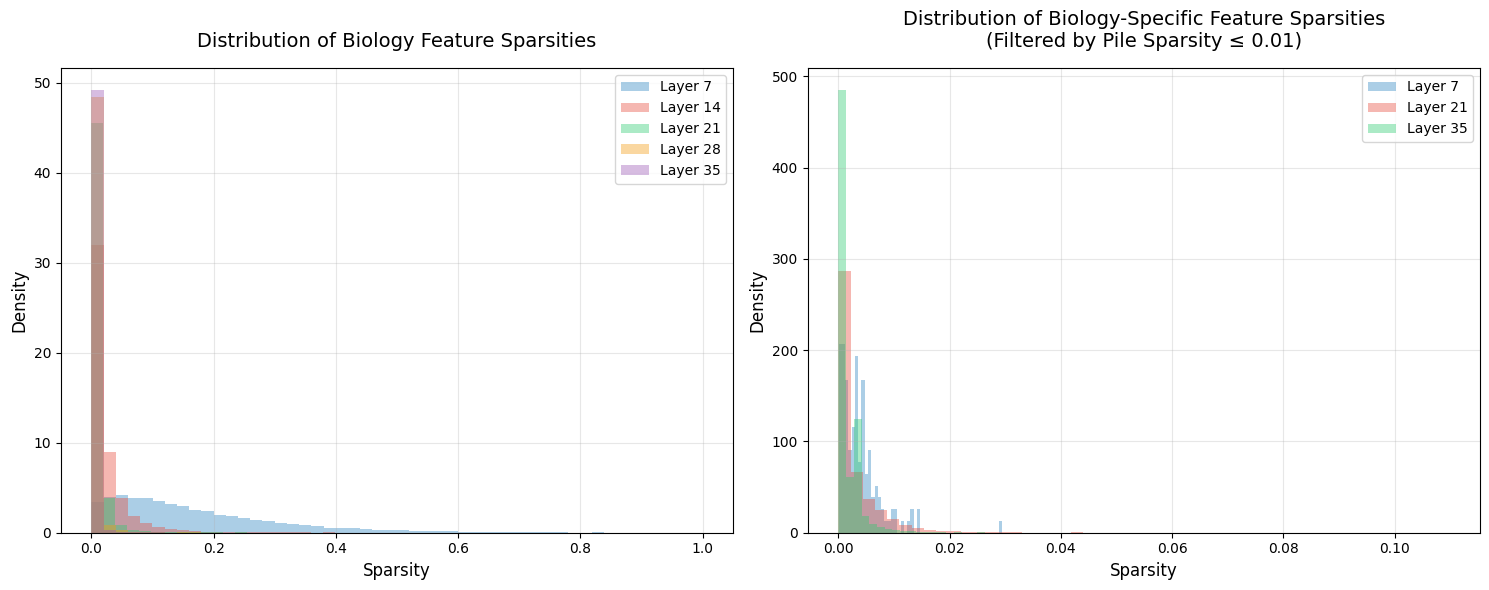

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for different layers - using a color palette with 5 distinct colors
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple
alphas = 0.4

# Plot 1: Raw biology sparsities
for layer, color in zip(sparsity_dfs.keys(), colors):
    sparsity_df = sparsity_dfs[layer]
    ax1.hist(sparsity_df["bio_sparsity"], bins=50, alpha=alphas, 
             color=color, label=f'Layer {layer}', density=True)

ax1.set_title('Distribution of Biology Feature Sparsities', fontsize=14, pad=15)
ax1.set_xlabel('Sparsity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
# ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Filtered biology sparsities
for layer, color in zip(sae_layers, colors):
    sparsity_df = sparsity_dfs[layer]
    filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
    # Only plot non-zero values
    filtered_bio_sparsity = filtered_bio_sparsity[filtered_bio_sparsity > 0]
    ax2.hist(filtered_bio_sparsity, bins=50, alpha=alphas, 
             color=color, label=f'Layer {layer}', density=True)

ax2.set_title('Distribution of Biology-Specific Feature Sparsities\n(Filtered by Pile Sparsity ≤ 0.01)', fontsize=14, pad=15)
ax2.set_xlabel('Sparsity', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
# ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

### Filter Features for Bio-Relevant

In [ ]:
import requests
import asyncio

url = "https://www.neuronpedia.org/api/explanation/export"

sae_layer = 7
headers = {"X-Api-Key": os.getenv("NEURONPEDIA_API_KEY")}
params = {"modelId": "gemma-2-9b", "saeId": f"{sae_layer}-gemmascope-res-16k"}
# params = {"modelId": "gpt2-small", "saeId": "6-res-jb"}

response = requests.get(url, headers=headers, params=params)
print(len(response.json()))
explanations_df = pd.DataFrame(response.json())
explanations_df["index"] = explanations_df["index"].astype(int)
explanations_df = explanations_df.set_index("index").sort_index()


In [ ]:
sparsity_df = sparsity_dfs[sae_layer]
filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.05, 1, 0) * sparsity_df["bio_sparsity"]
features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
# features = features_sorted.head(1000).index.tolist()
features = features_sorted[features_sorted > 0].index.tolist()

# print(f"{len(features)=}, {features=}")


In [84]:
from openai import AsyncOpenAI
import asyncio
import time

async_client = AsyncOpenAI(api_key=os.getenv("OPENROUTER_API_KEY"), base_url="https://openrouter.ai/api/v1")

async def check_related(feature_description):
    response = await async_client.chat.completions.create(
        model="openai/gpt-4o-mini",
        messages=[{"role": "user", "content": f"Is the following description clearly and closely related to biology?\n{feature_description}\nRespond with one word, 'Yes' or 'No'."}],
        temperature=0
    )
    return "yes" in response.choices[0].message.content.lower()

# with semaphore and rate limiting
semaphore = asyncio.Semaphore(500)
async def check_related_semaphore(feature_description):
    async with semaphore:
        result = await check_related(feature_description)
        # await asyncio.sleep(60)  # Wait 1 second after each request
        return result

tasks = [check_related_semaphore(explanations_df.loc[feature_idx, "description"]) for feature_idx in features]
results = await asyncio.gather(*tasks)

In [88]:
for feature_idx, result in zip(features, results):
    if result:
        print(f"{feature_idx=}, {explanations_df.loc[feature_idx, 'description']=}")
        # break

feature_idx=4261, explanations_df.loc[feature_idx, 'description']=' terms and concepts related to cells and their functions, particularly in a biological or medical context'
feature_idx=10408, explanations_df.loc[feature_idx, 'description']='terms related to biomedical analysis and identification processes'
feature_idx=11230, explanations_df.loc[feature_idx, 'description']=" references to humanity's impact on the environment"
feature_idx=10123, explanations_df.loc[feature_idx, 'description']='terms related to liver health and diseases'
feature_idx=1225, explanations_df.loc[feature_idx, 'description']='specific terms related to biological concepts and medical terminology'
feature_idx=8112, explanations_df.loc[feature_idx, 'description']='terms related to human characteristics and conditions'
feature_idx=9297, explanations_df.loc[feature_idx, 'description']='references to soil and its various characteristics or properties'
feature_idx=7762, explanations_df.loc[feature_idx, 'description']

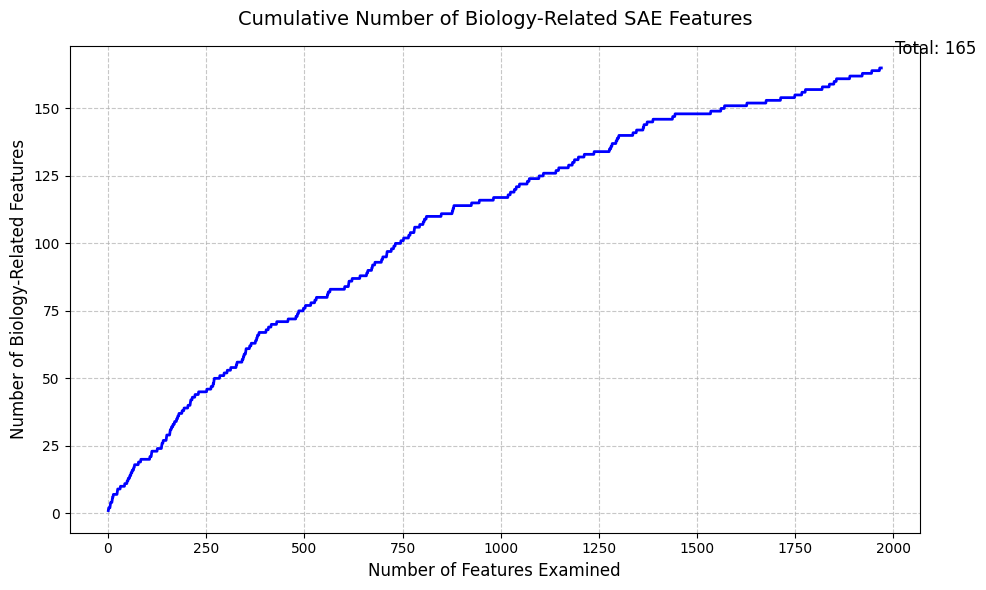

In [97]:
# Create cumulative sum plot
cumsum = np.cumsum([1 if r else 0 for r in results])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results) + 1), cumsum, 'b-', linewidth=2)

plt.title('Cumulative Number of Biology-Related SAE Features', fontsize=14, pad=15)
plt.xlabel('Number of Features Examined', fontsize=12)
plt.ylabel('Number of Biology-Related Features', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add final count annotation
plt.annotate(f'Total: {cumsum[-1]}', 
            xy=(len(results), cumsum[-1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=12)

plt.tight_layout()

# Try Unlearning Approaches

## Clamp SAE Feature

### Try Clamping

In [10]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states
    
batch = bio_ce_task.get_batch()["abstract"]
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=200)
inputs = {k: v.cuda() for k, v in inputs.items()}
print(inputs["input_ids"].shape)
print(inputs["attention_mask"].sum())


with torch.no_grad():
    target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
print(target_act.shape)


sae = sae_dict[21]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()
with torch.amp.autocast(device_type="cuda"):
    sae_acts = sae.encode(target_act)
print(sae_acts.shape)


recon = sae.decode(sae_acts)
with torch.no_grad():
    if len(sae_acts.shape) == 2:
        print(1 - torch.mean((recon - target_act.to(torch.float32)) **2) / (target_act.to(torch.float32).var()))
    else:
        print(1 - torch.mean((recon[..., 1:] - target_act[..., 1:].to(torch.float32)) **2) / (target_act[..., 1:].to(torch.float32).var()))

torch.Size([16, 200])
tensor(2901, device='cuda:0')
torch.Size([2885, 3584])
torch.Size([2885, 16384])
tensor(0.8997, device='cuda:0')


In [9]:
# calculate my own sae acts
import einops

with torch.no_grad():
    with torch.amp.autocast(device_type="cuda"):
        sae_acts_mine = einops.einsum(target_act, sae.W_enc, "batch hidden, hidden feature -> batch feature") + sae.b_enc
        sae_acts_mine = (sae_acts_mine > sae.threshold) * sae_acts_mine

    assert torch.allclose(sae_acts, sae_acts_mine, atol=1e-4)

    with torch.amp.autocast(device_type="cuda"):
        recon_mine = einops.einsum(sae_acts, sae.W_dec, "batch feature, feature hidden -> batch hidden") + sae.b_dec
    
    print((recon_mine - recon).abs().mean())
    # assert torch.allclose(recon_mine, recon, atol=1e-2), f"Reconstruction mismatch: {(recon_mine - recon).abs().mean()}"


tensor(0.0006, device='cuda:0')


In [10]:
feature = 4946
print((sae_acts[:, 4946] != 0).float().mean())

feature_w = sae.W_enc[:, feature]
feature_b = sae.b_enc[feature]
threshold = sae.threshold[feature]

with torch.no_grad():
    with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
        feature_acts = einops.einsum(target_act, feature_w, "batch hidden, hidden -> batch") + feature_b
        print(feature_acts.shape)
        feature_acts = (feature_acts > threshold) * feature_acts
        print((feature_acts - sae_acts[:, feature]).abs().max())

    print((feature_acts - sae_acts[:, feature]).abs().max())

    # with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
    #     recon_mine = einops.einsum(feature_acts, sae.W_dec, "batch, hidden -> batch hidden")
    # plt.scatter(feature_acts.cpu().float().detach().numpy(), sae_acts[:, feature].cpu().float().detach().numpy())


tensor(0.3867, device='cuda:0')
torch.Size([3057])
tensor(0.0163, device='cuda:0')
tensor(0.0163, device='cuda:0')


In [38]:
def clamp_sae_feature(act, sae, feature, clamp_value=0):
    feature_w = sae.W_enc[:, feature]
    feature_b = sae.b_enc[feature]
    threshold = sae.threshold[feature]
    feature_vec = sae.W_dec[feature]

    with torch.amp.autocast(device_type="cuda"):
        feature_acts = einops.einsum(act, feature_w, "batch hidden, hidden -> batch") + feature_b
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
    
    return act + einops.einsum(clamped_feature_diff, feature_vec, "batch, hidden -> batch hidden")

with torch.no_grad():
    clamped_recon = clamp_sae_feature(target_act, sae, feature, clamp_value=-1)



In [39]:
print(sae_acts[:, feature])
print(sae_acts.shape)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 5.1716, 6.3747], device='cuda:0',
       grad_fn=<SelectBackward0>)
torch.Size([3057, 16384])


In [44]:
((target_act - clamped_recon) - (recon - real_clamped_recon)).var()

tensor(3.5431e-09, device='cuda:0', grad_fn=<VarBackward0>)

In [46]:
feature_clamped_acts = torch.where(sae_acts[:, feature] > 0, -1, 0)
sae_clamped_acts = sae_acts.clone()
sae_clamped_acts[:, feature] = feature_clamped_acts
real_clamped_recon = sae.decode(sae_clamped_acts)

print((clamped_recon - real_clamped_recon).var())

with torch.no_grad():
    if len(sae_acts.shape) == 2:
        print("R^2:", 1 - torch.mean((real_clamped_recon - clamped_recon) **2) / (real_clamped_recon.var()))
    # else:
    #     print(1 - torch.mean((recon[..., 1:] - target_act[..., 1:].to(torch.float32)) **2) / (target_act[..., 1:].to(torch.float32).var()))

tensor(2.1042, device='cuda:0', grad_fn=<VarBackward0>)
R^2: tensor(0.8875, device='cuda:0')


In [36]:
with torch.no_grad():
    diff_matrix = sae.decode(sae_acts) - sae.decode(sae_clamped_acts)
    print(diff_matrix)

    diff_matrix_nonzero = einops.rearrange(diff_matrix[diff_matrix != 0], "(batch hidden) -> batch hidden", hidden=diff_matrix.shape[-1])
    print(diff_matrix_nonzero.shape)
    U, S, V = torch.linalg.svd(diff_matrix_nonzero)
    print("Singular values:", S)
    print("\nShape of U:", U.shape)
    print("Shape of V:", V.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1120, -0.1418,  0.0560,  ..., -0.0353, -0.0607,  0.1637],
        [ 0.1338, -0.1694,  0.0669,  ..., -0.0421, -0.0725,  0.1956]],
       device='cuda:0')
torch.Size([1182, 3584])
Singular values: tensor([7.0217e+02, 2.3684e-04, 7.2527e-05,  ..., 2.7409e-06, 2.7151e-06,
        2.5923e-06], device='cuda:0')

Shape of U: torch.Size([1182, 1182])
Shape of V: torch.Size([3584, 3584])


### Test Clamping

In [12]:
def clamp_sae_feature(act, sae, features, clamp_value=0):
    if isinstance(features, int):
        features = [features]
    feature_w = sae.W_enc[:, features] # [hidden, n_features]
    feature_b = sae.b_enc[features] # [n_features]
    threshold = sae.threshold[features] # [n_features]
    feature_vec = sae.W_dec[features] # [n_features, hidden]

    # print(f"{feature_w.shape=}, {feature_b.shape=}, {threshold.shape=}, {feature_vec.shape=}, {act.shape=}")

    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_acts = einops.einsum(act, feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
        # print(f"{feature_acts.shape=}")
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
        # print(f"{clamped_feature_diff.shape=}")
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
        output = act + einops.einsum(clamped_feature_diff, feature_vec, "... n_features, n_features hidden -> ... hidden")
    return output

def clamp_sae_feature_decode(act, sae, features, clamp_value=0):
    sae_acts = sae.encode(act)
    if isinstance(features, int):
        features = [features]
    # print(f"{sae_acts.shape=}")
    # print(f"{sae_acts[..., features]=}")
    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_clamped_acts = torch.where(sae_acts[..., features] > 0, clamp_value, 0.)
        sae_acts[..., features] = feature_clamped_acts
        output = sae.decode(sae_acts).to(dtype)
    return output

def get_hook(sae, features, clamp_value=0, decode=False):
    def clamp_hook(module, inputs, output):
        if decode:
            new_output = (clamp_sae_feature_decode(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        else:
            new_output = (clamp_sae_feature(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        return new_output
    return clamp_hook

@contextlib.contextmanager
def temporary_forward_hook(module, hook_fn):
    """
    Registers the given hook function to `module` and removes it on exit.
    """
    handle = module.register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()


#### Clamp One Feature

In [14]:
feature_idx = 4946
clamp_value = -1



sae = sae_dict[21]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()

# For a GPT2-like model
inputs = tokenizer("A submicroscopic particle that can only replicate in a organism's living cells is called a", return_tensors="pt", padding=True, truncation=True, max_length=200)
inputs = {k: v.cuda() for k, v in inputs.items()}
with torch.no_grad():
    output = model(**inputs)
print(tokenizer.batch_decode(output.logits.argmax(dim=-1).cpu().numpy().squeeze()))

layer_module = model.model.layers[sae_layer]
with temporary_forward_hook(layer_module, get_hook(sae, feature_idx, clamp_value=-100)):
    inputs = tokenizer("A submicroscopic particle that can only replicate in a organism's living cells is called a", return_tensors="pt", padding=True, truncation=True, max_length=200)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        output = model(**inputs)
    print(tokenizer.batch_decode(output.logits.argmax(dim=-1).cpu().numpy().squeeze()))

['<h1>', ' ', '-', 'roscopic', ' particle', ' of', ' is', ' be', ' be', ' inside', ' a', ' living', ' is', 's', ' cells', ' cells', ' is', ' called', ' a', ' virus']
['<h1>', ' ', '-', 'roscopic', ' particle', ' of', ' is', ' be', ' be', ' inside', ' a', ' living', ' is', 's', ' cells', ' cells', ' is', ' called', ' a', ' virus']


In [34]:
from tasks.general_capabilities.MCTask_redo import run_general_evals
clamp_value = -100
sae_layer = 21
layer_module = model.model.layers[sae_layer]
feature_indices = [ 4946,  1013,  9879, 11463,  9715,  3300,  3179,  2006, 10496,  1459,
         6620, 12231,  7340, 14570, 10422,  3706,  8465,  6170,    17, 11002]


# print("Approximate clamping (simulating effect of clamping feature)")
# with temporary_forward_hook(layer_module, get_hook(sae, feature_indices, clamp_value=clamp_value)):
#     accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
#     print(f"Accuracy: {accuracy}")

#     mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
#     print(mmlu)

print("Full clamping (clamping fully calculated feature, and returning SAE-decoded output)")
with temporary_forward_hook(layer_module, get_hook(sae, feature_indices, clamp_value=clamp_value, decode=True)):
    accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
    print(f"Accuracy: {accuracy}")

    mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
    print(mmlu)


Full clamping (clamping fully calculated feature, and returning SAE-decoded output)
output.shape=torch.Size([16, 196, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 199, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 259, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 336, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 205, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 166, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 153, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 154, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 228, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 119, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 145, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 713, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([16, 140, 3584]), output.dtype=torch.bfloat16
output

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


output.shape=torch.Size([5, 818, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1108, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 748, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1938, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1047, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1007, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 676, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1206, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1563, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 796, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1658, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1558, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 1647, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([5, 953, 3584]), output.dtype=torch.bfloat16
output.shape=torch.Size([

#### Graph of Clamping Features

In [13]:
from tqdm.auto import tqdm
import pandas as pd
import itertools

# Define parameter space
decode_values = [True, False]
sae_layers = [7, 21, 35]
# n_feature_options = [10, 20, 50, 200, 1000]
n_feature_options = [10, 50, 200, 1000]
clamp_values = [0, -1, -10, -100, -1000]

# Create iterator for all combinations
total_combinations = len(decode_values) * len(sae_layers) * len(n_feature_options) * len(clamp_values)

# Initialize results list to store dictionaries
results_list = []

# Create progress bar
pbar = tqdm(total=total_combinations, desc="Testing combinations")

for sae_layer in sae_layers:
    layer_module = model.model.layers[sae_layer]
    sae = sae_dict[sae_layer]
    if next(sae.parameters()).device.type != "cuda":
        sae = sae.cuda()

    param_iterator = itertools.product(
        decode_values,
        # sae_layers,
        n_feature_options,
        clamp_values
    )
    for decode, n_features, clamp_value in param_iterator:            
        # Get sparsity data for this layer
        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        features = features_sorted.head(n_features).index.tolist()
        
        pbar.set_description(f"Layer {sae_layer}: Testing {n_features} features, clamp={clamp_value}, decode={decode}")
        
        with temporary_forward_hook(layer_module, get_hook(sae, features, clamp_value=clamp_value, decode=decode)):
            bio_accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
            mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=5, device="cuda")["MMLU"]
            
            # Store results in list
            results_list.append({
                'decode': decode,
                'layer': sae_layer,
                'n_features': n_features,
                'clamp_value': clamp_value,
                'bio_accuracy': bio_accuracy,
                'mmlu': mmlu
            })
            
            # Print current result
            print(f"\nResults for layer {sae_layer}, {n_features} features, clamp={clamp_value}, decode={decode}:")
            print(f"Bio accuracy: {bio_accuracy:.3f}")
            print(f"MMLU: {mmlu:.3f}")
        
        pbar.update(1)
    # Move SAE back to CPU after finishing with this layer
    sae = sae.cpu()

pbar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

display(results_df)

Testing combinations:   0%|          | 0/120 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=0, decode=True:
Bio accuracy: 0.592
MMLU: 0.660


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1, decode=True:
Bio accuracy: 0.591
MMLU: 0.670


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-10, decode=True:
Bio accuracy: 0.595
MMLU: 0.670


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-100, decode=True:
Bio accuracy: 0.559
MMLU: 0.640


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1000, decode=True:
Bio accuracy: 0.470
MMLU: 0.450


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=0, decode=True:
Bio accuracy: 0.595
MMLU: 0.650


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-1, decode=True:
Bio accuracy: 0.588
MMLU: 0.640


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-10, decode=True:
Bio accuracy: 0.593
MMLU: 0.650


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-100, decode=True:
Bio accuracy: 0.457
MMLU: 0.400


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-1000, decode=True:
Bio accuracy: 0.243
MMLU: 0.270


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=0, decode=True:
Bio accuracy: 0.590
MMLU: 0.640


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-1, decode=True:
Bio accuracy: 0.606
MMLU: 0.640


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-10, decode=True:
Bio accuracy: 0.576
MMLU: 0.610


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-100, decode=True:
Bio accuracy: 0.259
MMLU: 0.240


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-1000, decode=True:
Bio accuracy: 0.231
MMLU: 0.240


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=0, decode=True:
Bio accuracy: 0.571
MMLU: 0.590


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-1, decode=True:
Bio accuracy: 0.572
MMLU: 0.560


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-10, decode=True:
Bio accuracy: 0.478
MMLU: 0.490


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-100, decode=True:
Bio accuracy: 0.239
MMLU: 0.280


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-1000, decode=True:
Bio accuracy: 0.240
MMLU: 0.210


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=0, decode=False:
Bio accuracy: 0.708
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1, decode=False:
Bio accuracy: 0.718
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-10, decode=False:
Bio accuracy: 0.714
MMLU: 0.710


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-100, decode=False:
Bio accuracy: 0.731
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1000, decode=False:
Bio accuracy: 0.680
MMLU: 0.580


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=0, decode=False:
Bio accuracy: 0.702
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-1, decode=False:
Bio accuracy: 0.740
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-10, decode=False:
Bio accuracy: 0.708
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-100, decode=False:
Bio accuracy: 0.675
MMLU: 0.580


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 50 features, clamp=-1000, decode=False:
Bio accuracy: 0.259
MMLU: 0.260


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=0, decode=False:
Bio accuracy: 0.709
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-1, decode=False:
Bio accuracy: 0.712
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-10, decode=False:
Bio accuracy: 0.724
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-100, decode=False:
Bio accuracy: 0.428
MMLU: 0.310


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 200 features, clamp=-1000, decode=False:
Bio accuracy: 0.243
MMLU: 0.240


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=0, decode=False:
Bio accuracy: 0.709
MMLU: 0.710


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-1, decode=False:
Bio accuracy: 0.681
MMLU: 0.710


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-10, decode=False:
Bio accuracy: 0.686
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-100, decode=False:
Bio accuracy: 0.233
MMLU: 0.250


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 1000 features, clamp=-1000, decode=False:
Bio accuracy: 0.251
MMLU: 0.210


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=0, decode=True:
Bio accuracy: 0.614
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-1, decode=True:
Bio accuracy: 0.607
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-10, decode=True:
Bio accuracy: 0.623
MMLU: 0.590


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-100, decode=True:
Bio accuracy: 0.602
MMLU: 0.590


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-1000, decode=True:
Bio accuracy: 0.433
MMLU: 0.560


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=0, decode=True:
Bio accuracy: 0.621
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-1, decode=True:
Bio accuracy: 0.616
MMLU: 0.590


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-10, decode=True:
Bio accuracy: 0.608
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-100, decode=True:
Bio accuracy: 0.583
MMLU: 0.610


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-1000, decode=True:
Bio accuracy: 0.348
MMLU: 0.380


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=0, decode=True:
Bio accuracy: 0.615
MMLU: 0.590


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-1, decode=True:
Bio accuracy: 0.622
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-10, decode=True:
Bio accuracy: 0.611
MMLU: 0.610


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-100, decode=True:
Bio accuracy: 0.509
MMLU: 0.520


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-1000, decode=True:
Bio accuracy: 0.240
MMLU: 0.210


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=0, decode=True:
Bio accuracy: 0.613
MMLU: 0.570


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-1, decode=True:
Bio accuracy: 0.582
MMLU: 0.570


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-10, decode=True:
Bio accuracy: 0.538
MMLU: 0.550


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-100, decode=True:
Bio accuracy: 0.257
MMLU: 0.250


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-1000, decode=True:
Bio accuracy: 0.238
MMLU: 0.230


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=0, decode=False:
Bio accuracy: 0.714
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-1, decode=False:
Bio accuracy: 0.713
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-10, decode=False:
Bio accuracy: 0.724
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-100, decode=False:
Bio accuracy: 0.718
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 10 features, clamp=-1000, decode=False:
Bio accuracy: 0.564
MMLU: 0.670


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=0, decode=False:
Bio accuracy: 0.720
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-1, decode=False:
Bio accuracy: 0.711
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-10, decode=False:
Bio accuracy: 0.724
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-100, decode=False:
Bio accuracy: 0.698
MMLU: 0.690


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 50 features, clamp=-1000, decode=False:
Bio accuracy: 0.430
MMLU: 0.470


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=0, decode=False:
Bio accuracy: 0.717
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-1, decode=False:
Bio accuracy: 0.717
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-10, decode=False:
Bio accuracy: 0.720
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-100, decode=False:
Bio accuracy: 0.680
MMLU: 0.600


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 200 features, clamp=-1000, decode=False:
Bio accuracy: 0.261
MMLU: 0.270


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=0, decode=False:
Bio accuracy: 0.708
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-1, decode=False:
Bio accuracy: 0.708
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-10, decode=False:
Bio accuracy: 0.701
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-100, decode=False:
Bio accuracy: 0.242
MMLU: 0.240


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 21, 1000 features, clamp=-1000, decode=False:
Bio accuracy: 0.241
MMLU: 0.220


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=0, decode=True:
Bio accuracy: 0.738
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-1, decode=True:
Bio accuracy: 0.738
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-10, decode=True:
Bio accuracy: 0.736
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-100, decode=True:
Bio accuracy: 0.730
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-1000, decode=True:
Bio accuracy: 0.725
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=0, decode=True:
Bio accuracy: 0.732
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-1, decode=True:
Bio accuracy: 0.738
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-10, decode=True:
Bio accuracy: 0.733
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-100, decode=True:
Bio accuracy: 0.734
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-1000, decode=True:
Bio accuracy: 0.715
MMLU: 0.670


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=0, decode=True:
Bio accuracy: 0.733
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-1, decode=True:
Bio accuracy: 0.743
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-10, decode=True:
Bio accuracy: 0.725
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-100, decode=True:
Bio accuracy: 0.736
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-1000, decode=True:
Bio accuracy: 0.578
MMLU: 0.620


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=0, decode=True:
Bio accuracy: 0.732
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-1, decode=True:
Bio accuracy: 0.735
MMLU: 0.700


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-10, decode=True:
Bio accuracy: 0.736
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-100, decode=True:
Bio accuracy: 0.646
MMLU: 0.570


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-1000, decode=True:
Bio accuracy: 0.243
MMLU: 0.140


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=0, decode=False:
Bio accuracy: 0.720
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-1, decode=False:
Bio accuracy: 0.730
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-10, decode=False:
Bio accuracy: 0.706
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-100, decode=False:
Bio accuracy: 0.709
MMLU: 0.710


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 10 features, clamp=-1000, decode=False:
Bio accuracy: 0.719
MMLU: 0.680


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=0, decode=False:
Bio accuracy: 0.737
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-1, decode=False:
Bio accuracy: 0.701
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-10, decode=False:
Bio accuracy: 0.726
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-100, decode=False:
Bio accuracy: 0.726
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 50 features, clamp=-1000, decode=False:
Bio accuracy: 0.702
MMLU: 0.690


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=0, decode=False:
Bio accuracy: 0.718
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-1, decode=False:
Bio accuracy: 0.723
MMLU: 0.720


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-10, decode=False:
Bio accuracy: 0.719
MMLU: 0.710


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-100, decode=False:
Bio accuracy: 0.715
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 200 features, clamp=-1000, decode=False:
Bio accuracy: 0.558
MMLU: 0.620


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=0, decode=False:
Bio accuracy: 0.705
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-1, decode=False:
Bio accuracy: 0.734
MMLU: 0.730


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-10, decode=False:
Bio accuracy: 0.717
MMLU: 0.690


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-100, decode=False:
Bio accuracy: 0.487
MMLU: 0.380


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 35, 1000 features, clamp=-1000, decode=False:
Bio accuracy: 0.286
MMLU: 0.150


,decode,layer,n_features,clamp_value,bio_accuracy,mmlu
0,True,7,10,0,0.591508,0.66
1,True,7,10,-1,0.590893,0.67
2,True,7,10,-10,0.594849,0.67
3,True,7,10,-100,0.558896,0.64
4,True,7,10,-1000,0.469585,0.45
...,...,...,...,...,...,...
115,False,35,1000,0,0.704993,0.73
116,False,35,1000,-1,0.734353,0.73
117,False,35,1000,-10,0.717124,0.69
118,False,35,1000,-100,0.486902,0.38


In [15]:
results_df.to_csv("sae_unlearning_results.csv", index=False)

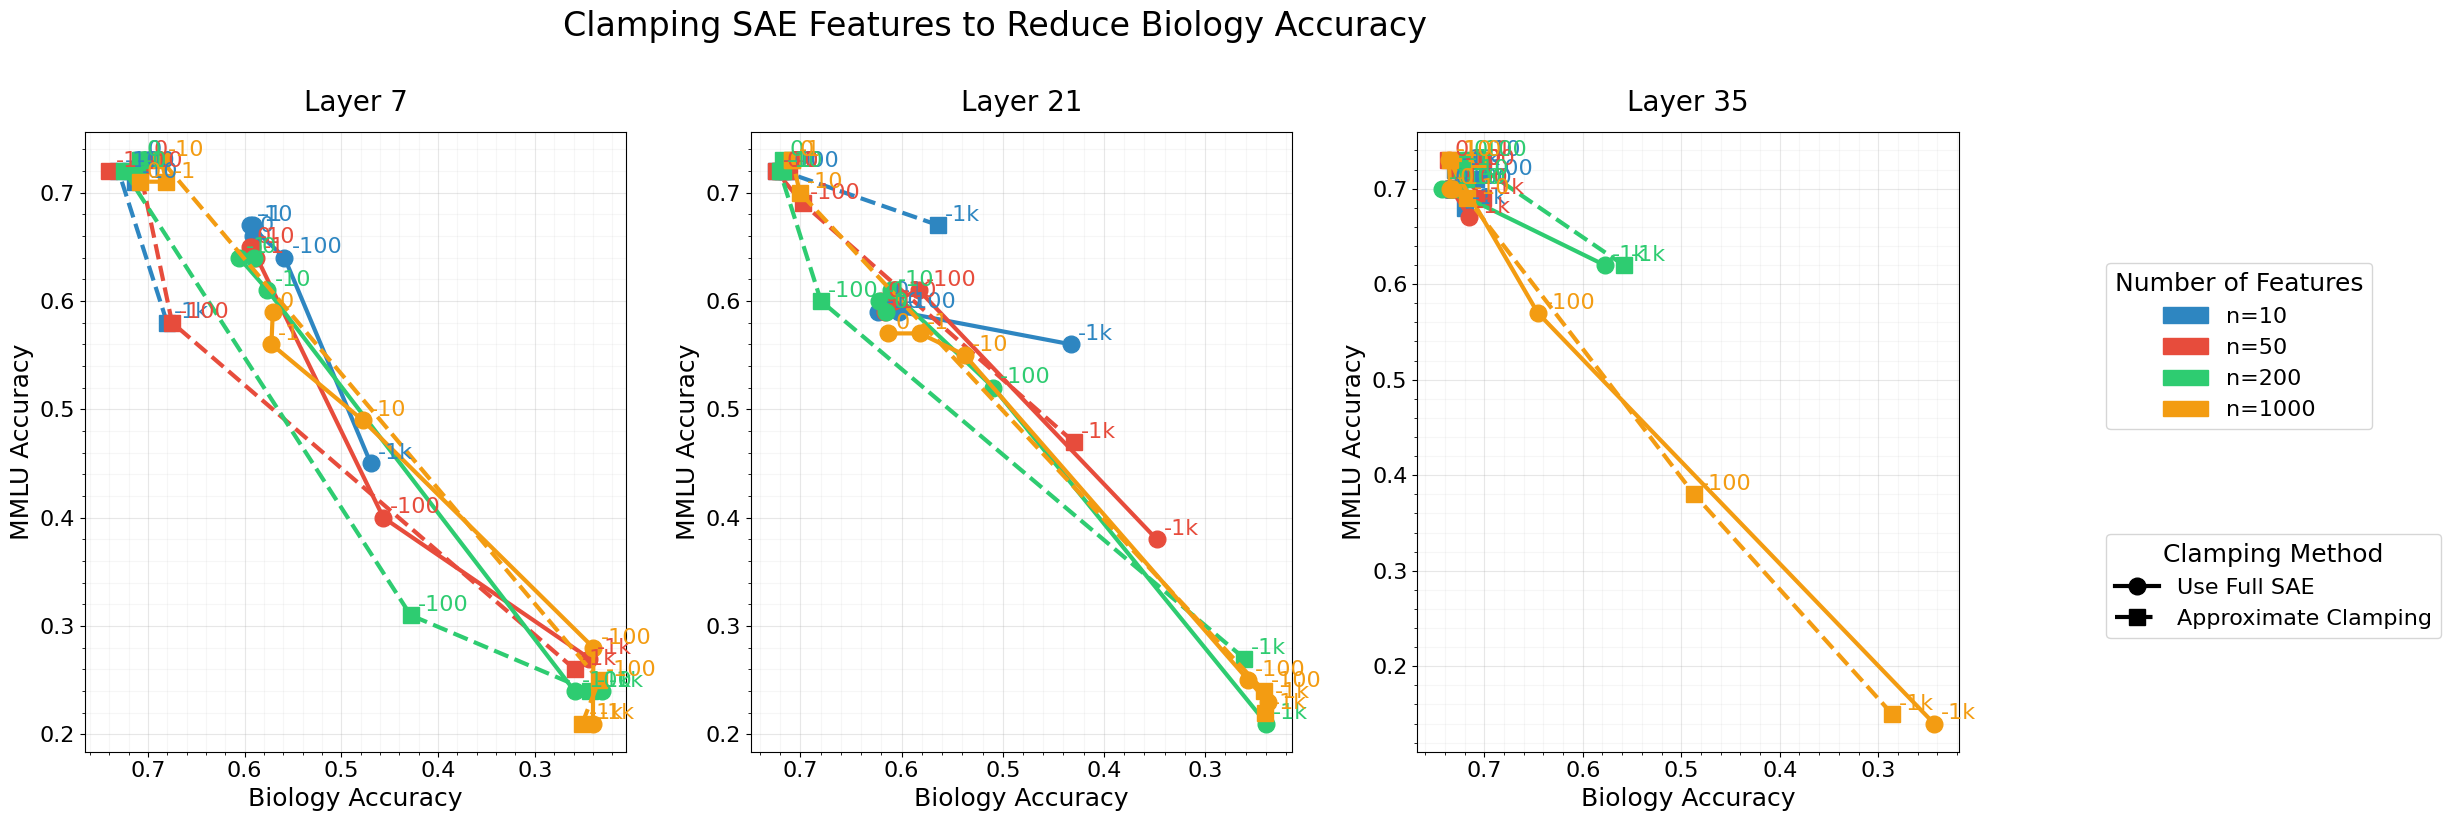

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set style and figure size
plt.figure(figsize=(20, 8))

# Define colors for different n_features - using a custom color palette
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple
n_features_unique = sorted(results_df['n_features'].unique())

# Define styles for decode True/False - increased sizes
decode_styles = {
    True: {'linestyle': '-', 'marker': 'o', 'markersize': 12, 'linewidth': 3},
    False: {'linestyle': '--', 'marker': 's', 'markersize': 12, 'linewidth': 3}
}

# Plot for each layer
for layer_idx, layer in enumerate(results_df['layer'].unique()):
    plt.subplot(1, len(results_df['layer'].unique()), layer_idx + 1)
    
    # Plot for each combination of n_features and decode
    for n_feat, color in zip(n_features_unique, colors):
        for decode in [True, False]:
            # Filter data
            mask = (results_df['layer'] == layer) & \
                  (results_df['n_features'] == n_feat) & \
                  (results_df['decode'] == decode)
            data = results_df[mask].sort_values('clamp_value')
            
            # Plot line and points without labels (we'll create custom legend)
            plt.plot(data['bio_accuracy'], data['mmlu'], 
                    color=color,
                    **decode_styles[decode])
            # Add clamp value annotations
            for _, row in data.iterrows():
                # Format clamp value text
                if row['clamp_value'] == 0:
                    clamp_text = '0'
                elif abs(row['clamp_value']) >= 1000:
                    clamp_text = f'{int(row["clamp_value"]/1000)}k'
                else:
                    clamp_text = str(int(row['clamp_value']))
                
                # Position text with small offset
                plt.annotate(clamp_text,
                           (row['bio_accuracy'], row['mmlu']),
                           xytext=(5, 3), textcoords='offset points',
                           fontsize=16, color=color)


    # plt.title(f'Clamping SAE Features from Layer {layer} to Reduce Bio Accuracy', fontsize=20, pad=15)
    plt.title(f'Layer {layer}', fontsize=20, pad=15)
    plt.xlabel('Biology Accuracy', fontsize=18)
    plt.ylabel('MMLU Accuracy', fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Reverse x-axis
    plt.gca().invert_xaxis()
    
    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.1)
    plt.minorticks_on()

plt.suptitle("Clamping SAE Features to Reduce Biology Accuracy", fontsize=24, y=1.02)
# Create custom legend
# First create the feature count legend handles
feature_handles = [mpatches.Patch(color=color, label=f'n={n_feat}') 
                  for color, n_feat in zip(colors, n_features_unique)]

# Create the decode type legend handles (in black)
decode_handles = [
    plt.Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=12, linewidth=3, label='Use Full SAE'),
    plt.Line2D([0], [0], color='black', linestyle='--', marker='s', markersize=12, linewidth=3, label='Approximate Clamping')
]

# Add two separate legends
# Feature count legend
plt.figlegend(handles=feature_handles, 
              loc='center left',
              bbox_to_anchor=(1.05, 0.6),
              title='Number of Features',
              fontsize=16,
              title_fontsize=18)

# Decode type legend
plt.figlegend(handles=decode_handles,
              loc='center left',
              bbox_to_anchor=(1.05, 0.3),
              title='Clamping Method',
              fontsize=16,
              title_fontsize=18)

# Adjust layout to prevent text overlap
plt.tight_layout()

# Gradient Update Unlearning

In [19]:
def rerouting_loss(act, original_act):
    # want to minimize the cosine similarity between act and original_act
    return torch.relu(torch.cosine_similarity(act, original_act, dim=-1))

def match_act_loss(act, target_act):
    return torch.norm(act - target_act, dim=-1, p=2, dtype=torch.float).nanmean()

In [ ]:
# set up dataset
batch_size = 8

bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=500)
print(pile_task.get_batch())

In [ ]:
class ActivationDataset:
    def __init__(self, original_model, activation_layers, buffer_size=256):
        self.original_model = original_model
        self.activation_layers = activation_layers
        self.buffer_size = buffer_size
        self.buffer = []
        self.buffer_idx = 0
        self.buffer_size = 0
        self.buffer_size = 0

    def __getitem__(self, idx):
        
    def refresh(self):
        


In [ ]:
# front load by 

## RMU/Circuit Breakers

## Match SAE Clamping